In [ ]:
import numpy as np
import pandas as pd
import struct
import io

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()

from scipy import signal
from tqdm import tqdm

from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

import os
import copy
import re
import cv2
from numba import njit

## Открываем файлы вторичного спектра

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# получаем список всех файлов в папке с данными
directory = "/content/drive/MyDrive/pulsar_data"
files = os.listdir(directory)
files.remove('readme.xlsx')
#files.remove('readme.gsheet')
#files.remove()
print(np.array(files))
print(np.array(files).shape)

['secspec_slice_512x201.bin'
 'raks02aa.514.lcp-rcp.averaged.secspec.1133x395.bin'
 'rags29j.771-USB.combined.512x516.1of1.frdelay.ifft.tr.fft.tr_amp.dat'
 'rags04ak.LCP-771-USB.957x2681.bin1of1.frdelay.ifft.tr.fft.tr_amp.dat'
 'raks24a.LCP-514-USB-2048x4031.combined.linear.datnormalized.av_c4.bin1of1.frdelay.ifft.tr.fft.tr_amp.dat'
 'rags04ao..LCP-771-USB.arc.512x144.bin'
 'rags04ah.RCP-514-USB.14336x267.bin'
 'rags04aj.514-USB.combined.2048x3389.1of1.frdelay.ifft.tr.fft.tr_amp.dat'
 'rags04ak.771-USB-1024x24759.combined.linear.1of1.frdelay.ifft.tr.fft.tr_amp.dat'
 'rags04ap_gb_ll_scnd.modified.512x3380.bin'
 'rags04ar_ar_rr_scnd.modified.512x3770.bin'
 'rags29e.LCP-514-USB.combined.2048x3259.dat.interpolate.bin1of1.frdelay.ifft.tr.fft.tr_amp.dat'
 'rags29g.514-USB-4096x2019.combined.linear.1of1.frdelay.ifft.tr.fft.tr_amp.dat'
 'rags29l.LCP-514-USB-2048x2012.combined.smooth.1of1.frdelay.ifft.tr.fft.tr_amp.dat'
 'rags29p.LCP-514-USB-2048x3033.combined.linear.av_c4.1of1.frdelay.ifft.tr.

In [ ]:
spectra_info = pd.read_csv(io.StringIO('''
raes06c64.514-USB.arc3.285x14336.transp.bin,raes06c,B0834+06,"1,27376833",324,16,65536,78,"0,0625","0,2137",Arecibo,26/04/12
rags04ah.RCP-514-USB.14336x267.bin,rags04ah,B0834+06,"1,273768292",324,16,65536,"55.52","0,0625","0,3002",Green Bank,08/12/14
rags04aj.514-USB.combined.2048x3389.1of1.frdelay.ifft.tr.fft.tr_amp.dat          ,rags04aj,B0823+26,"0,5306605117",324,16,2048,150,"0,0625","0,1111",Green Bank,11/03/15
rags04ak.771-USB-1024x24759.combined.linear.1of1.frdelay.ifft.tr.fft.tr_amp.dat  ,rags04ak,B0823+26,"0,5306605117",324,16,1024,219,"0,0625","0,0761",Green Bank,11/03/15
rags04ak.LCP-771-USB.957x2681.bin1of1.frdelay.ifft.tr.fft.tr_amp.dat,rags04ak,B0823+26,"0,5306605117",324,16,1024,219,"0,0625","0,0761",Green Bank,11/03/15
rags04ao..LCP-771-USB.arc.512x144.bin                                            ,rags04ao,B1929+10,"0,22651764",324,16,512,100,"0,0625","0,1667",Arecibo,05/05/15
secspec_slice_512x201.bin,rags04ao,B1929+10,"0,22651764",324,16,512,100,"0,0625","0,1667",Arecibo,05/05/15
rags04ap_gb_ll_scnd.modified.512x3380.bin                                        ,rags04ap,B1237+25,"1,38244911",324,16,512,"86.7","0,0625","0,1922",Green Bank,13/05/15
rags04ar_ar_rr_scnd.modified.512x3770.bin                                        ,rags04ar,B1237+25,"1,38244911",324,16,512,"86.7","0,0625","0,1922",Arecibo,07/06/15
rags29e.LCP-514-USB.combined.2048x3259.dat.interpolate.bin1of1.frdelay.ifft.tr.fft.tr_amp.dat,rags29e,B0919+06,"0,4306271",324,16,2048,117,"0,0625","0,1425",Arecibo,11/01/18
rags29g.514-USB-4096x2019.combined.linear.1of1.frdelay.ifft.tr.fft.tr_amp.dat,rags29g,B1133+16,"1,18791307",324,16,65536,"119.92","0,0625","0,1390",Arecibo,03/02/18
rags29j.771-USB.combined.512x516.1of1.frdelay.ifft.tr.fft.tr_amp.dat,rags29j,B1237+25,"1,382449103",324,16,512,119,"0,0625","0,1401",Arecibo,26/02/18
rags29l.LCP-514-USB-2048x2012.combined.smooth.1of1.frdelay.ifft.tr.fft.tr_amp.dat,rags29l,B1133+16,"1,187913066",324,16,2048,"119.5","0,0625","0,1395",Arecibo,28/03/18
rags29p.LCP-514-USB-2048x3033.combined.linear.av_c4.1of1.frdelay.ifft.tr.fft.tr_amp.dat,rags29p,B0919+06,"0,4306271",324,16,2048,87,"0,0625","0,1916",Arecibo,10/05/18
raks02aa.514.lcp-rcp.averaged.secspec.1133x395.bin,raks02aa,B1933+16 ,"0,3587384",1668,32,2048,90,"0,03125","0,1852",Arecibo,01/08/13
raks02aa.514.lcp-rcp.averaged.secspec.4096x636.bin,raks02aa,B1933+16 ,"0,3587384",1668,32,2048,90,"0,03125","0,1852",Arecibo,01/08/13
raks24d.LCP-771-USB-2048x261.combined.smooth.1of1.frdelay.ifft.tr.fft.tr_amp.dat,raks24d,B0919+06,"0,4306271",324,16,2048,118,"0,0625","0,1412",Arecibo,15/12/18
raks24e.LCP-514-USB-2048x1986.combined.smooth.1of1.frdelay.ifft.tr.fft.tr_amp.dat,raks24e,B1133+16,"1,187913066",324,16,2048,118,"0,0625","0,1412",Green Bank,17/12/18
rags04am.771-USB-2048x1409.combined.smooth.1of1.frdelay.ifft.tr.fft.tr_amp.dat,rags04am,B0919+06,"0,4306271",324,16,2048,125,"0,0625","0,1333",Arecibo,14/04/15
raks24a.LCP-514-USB-2048x4031.combined.linear.datnormalized.av_c4.bin1of1.frdelay.ifft.tr.fft.tr_amp.dat,raks24a,B0919+06,"0,4306271",324,16,2048,"115.7","0,0625","0,1441",Arecibo,16/11/18
'''), header=None)

spectra_info = spectra_info.set_axis(['file','code','pulsar','period','frequency','wide','channels','obs_time','time_step','freq_step','telescope','obs_data'], axis=1)
#spectra_info.drop(17, inplace=True)
spectra_info['file'] = spectra_info['file'].str.split(expand=True)
spectra_info


,file,code,pulsar,period,frequency,wide,channels,obs_time,time_step,freq_step,telescope,obs_data
0,raes06c64.514-USB.arc3.285x14336.transp.bin,raes06c,B0834+06,"1,27376833",324,16,65536,78.00,"0,0625","0,2137",Arecibo,26/04/12
1,rags04ah.RCP-514-USB.14336x267.bin,rags04ah,B0834+06,"1,273768292",324,16,65536,55.52,"0,0625","0,3002",Green Bank,08/12/14
2,rags04aj.514-USB.combined.2048x3389.1of1.frdel...,rags04aj,B0823+26,"0,5306605117",324,16,2048,150.00,"0,0625","0,1111",Green Bank,11/03/15
3,rags04ak.771-USB-1024x24759.combined.linear.1o...,rags04ak,B0823+26,"0,5306605117",324,16,1024,219.00,"0,0625","0,0761",Green Bank,11/03/15
4,rags04ak.LCP-771-USB.957x2681.bin1of1.frdelay....,rags04ak,B0823+26,"0,5306605117",324,16,1024,219.00,"0,0625","0,0761",Green Bank,11/03/15
5,rags04ao..LCP-771-USB.arc.512x144.bin,rags04ao,B1929+10,"0,22651764",324,16,512,100.00,"0,0625","0,1667",Arecibo,05/05/15
6,secspec_slice_512x201.bin,rags04ao,B1929+10,"0,22651764",324,16,512,100.00,"0,0625","0,1667",Arecibo,05/05/15
7,rags04ap_gb_ll_scnd.modified.512x3380.bin,rags04ap,B1237+25,"1,38244911",324,16,512,86.70,"0,0625","0,1922",Green Bank,13/05/15
8,rags04ar_ar_rr_scnd.modified.512x3770.bin,rags04ar,B1237+25,"1,38244911",324,16,512,86.70,"0,0625","0,1922",Arecibo,07/06/15
9,rags29e.LCP-514-USB.combined.2048x3259.dat.int...,rags29e,B0919+06,"0,4306271",324,16,2048,117.00,"0,0625","0,1425",Arecibo,11/01/18


In [ ]:
sizes = []
for file in files:
    sizestr = re.search(r'[0-9]+x[0-9]+', file) # получаем строку размера
    size = list(map(int, sizestr.group(0).split('x')))[::-1]
    #if file == 'raes06c64.514-USB.arc3.285x14336.bin':
    #    size = size[::-1]
    sizes.append(size)                # получаем отдельно размер
sizes = np.array(sizes)
print(sizes)

[[  201   512]
 [  395  1133]
 [  516   512]
 [ 2681   957]
 [ 4031  2048]
 [  144   512]
 [  267 14336]
 [ 3389  2048]
 [24759  1024]
 [ 3380   512]
 [ 3770   512]
 [ 3259  2048]
 [ 2019  4096]
 [ 2012  2048]
 [ 3033  2048]
 [  636  4096]
 [  261  2048]
 [ 1986  2048]
 [ 1409  2048]
 [14336   285]]


In [ ]:
# для удобства создаем список с информацией о файле (имя и размер)

raw_file_data = [[os.path.join(directory, filename), size]
                  for filename, size in zip(files, sizes)]

print(raw_file_data)

[['/content/drive/MyDrive/pulsar_data/secspec_slice_512x201.bin', array([201, 512])], ['/content/drive/MyDrive/pulsar_data/raks02aa.514.lcp-rcp.averaged.secspec.1133x395.bin', array([ 395, 1133])], ['/content/drive/MyDrive/pulsar_data/rags29j.771-USB.combined.512x516.1of1.frdelay.ifft.tr.fft.tr_amp.dat', array([516, 512])], ['/content/drive/MyDrive/pulsar_data/rags04ak.LCP-771-USB.957x2681.bin1of1.frdelay.ifft.tr.fft.tr_amp.dat', array([2681,  957])], ['/content/drive/MyDrive/pulsar_data/raks24a.LCP-514-USB-2048x4031.combined.linear.datnormalized.av_c4.bin1of1.frdelay.ifft.tr.fft.tr_amp.dat', array([4031, 2048])], ['/content/drive/MyDrive/pulsar_data/rags04ao..LCP-771-USB.arc.512x144.bin', array([144, 512])], ['/content/drive/MyDrive/pulsar_data/rags04ah.RCP-514-USB.14336x267.bin', array([  267, 14336])], ['/content/drive/MyDrive/pulsar_data/rags04aj.514-USB.combined.2048x3389.1of1.frdelay.ifft.tr.fft.tr_amp.dat', array([3389, 2048])], ['/content/drive/MyDrive/pulsar_data/rags04ak.771-

In [ ]:
def open_file(path, size):
    file = open(path, 'rb')

    bin = bytearray(file.read())
    bytesize = len(bin)/(size[0]*size[1])
    binlist = list(struct.unpack('f'*size[0]*size[1], bin))
    raw_data = np.array(binlist).reshape(size)
    file.close()
    #raw_data = np.fromfile(filename).reshape(size)

    return raw_data

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
raw_data = open_file(*raw_file_data[0])
ax.imshow(raw_data)
fig.savefig('superraw.png', dpi=100)

In [ ]:
# == ПРЕДОБРАБОТКА ==
def preprocess(raw_data, size, path, eps=5):
    reshape_list = [
        ['raks24a.LCP-514-USB-2048x4031.combined.linear.datnormalized.av_c4.bin1of1.frdelay.ifft.tr.fft.tr_amp.dat', 250],
        ['rags04aj.514-USB.combined.2048x3389.1of1.frdelay.ifft.tr.fft.tr_amp.dat', 400],
        ['rags04ak.771-USB-1024x24759.combined.linear.1of1.frdelay.ifft.tr.fft.tr_amp.dat', 500],
        ['rags29e.LCP-514-USB.combined.2048x3259.dat.interpolate.bin1of1.frdelay.ifft.tr.fft.tr_amp.dat', 250],
        ['rags04ap_gb_ll_scnd.modified.512x3380.bin', 100],
        ['rags04ar_ar_rr_scnd.modified.512x3770.bin', 200],
        ['rags29p.LCP-514-USB-2048x3033.combined.linear.av_c4.1of1.frdelay.ifft.tr.fft.tr_amp.dat', 200],
        [ 'raks24e.LCP-514-USB-2048x1986.combined.smooth.1of1.frdelay.ifft.tr.fft.tr_amp.dat', 400],
        ['rags04am.771-USB-2048x1409.combined.smooth.1of1.frdelay.ifft.tr.fft.tr_amp.dat', 250]
        ]
    reshape_name = [elem[0] for elem in reshape_list]
    reshape_size = [elem[1] for elem in reshape_list]

    x_size, y_size = size

    # Обрезаем половину, особенность преобразования Фурье
    data = np.empty_like(raw_data)
    data = raw_data.copy()
    if data.min() >= 0:
        data = np.log10(data)
    name = path.replace(directory+'/', '')
    if name in reshape_name:
        idx = reshape_name.index(name)
        data = data[(x_size-reshape_size[idx])//2:(x_size+reshape_size[idx])//2, :]
    if name == 'raes06c64.514-USB.arc3.285x14336.transp.bin':
        data = data.T
        x_size, y_size = y_size, x_size
    data = data[:, :int(y_size)//2]
    data = data.T
    data = data[::-1]

    new_shape = np.array(data.shape)
    return data, new_shape

In [ ]:
Data = []
for info in tqdm(raw_file_data):
    path, size = info
    raw_data = open_file(path, size)
    data, size = preprocess(raw_data, size, path)

    Data.append({'data': data,
                 'size': size})

100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


In [ ]:
fig, ax = plt.subplots(4, 5, figsize = (50, 40))
for i in tqdm(range(4)):
    for j in range(5):
        k = 5*i+j
        data = Data[k]['data']
        name = raw_file_data[k][0]
        ax[i][j].imshow(data, aspect='auto', origin='lower')
        ax[i][j].set_title(f"{k}\n{name.replace(directory+'/', '')}")
fig.savefig('raw.png', dpi=100)

100%|██████████| 4/4 [00:00<00:00, 40.11it/s]


## Алгоритм Бредли-Рота -- Успех
Статья: https://habr.com/ru/articles/278435/

Используется идея интегральных изображений, нахождение порога бинаризации с их помощью

In [ ]:
@njit
def cross(img, x1, x2, y1, y2):
    return img[y2][x2] - img[y1][x2] - img[y2][x1] + img[y1][x1]

@njit
def condition(int_img, src, i, j, d, t):
    x1, x2 = max(0, j-d), min(j+d, src.shape[1]-1)
    y1, y2 = max(0, i-d), min(i+d, src.shape[0]-1)
    return (src[i][j]*(x2-x1)*(y2-y1) < cross(int_img, x1, x2, y1, y2)*(1.0-t))

In [ ]:
@njit
def bradley_threshold(src):
    width = src.shape[1]
    height = src.shape[0]

    s = min(width, height)
    d = int(s/4)
    t = 0.05
    #int_img = src.cumsum(axis=0).cumsum(axis=1)

    int_img = np.zeros_like(src)
    for i in range(height):
        int_img[i][0] = src[i][0]
    for j in range(1, width):
        for i in range(height):
            int_img[i][j] = int_img[i][j-1]+src[i][j]
    for i in range(1, height):
        for j in range(width):
            int_img[i][j] += int_img[i-1][j]

    res = np.array([[0 if (condition(int_img, src, i, j, d, t)) else 1 for j in range(width)] for i in range(height)])
    return res

## Важно! Вырезать вертикальную линию следует после фильтрации алгоритмом Бредли-Рота! Иначе алгорит сработает неправильно!

In [ ]:
B_Data = []
Cut_Data = []
for file in tqdm(Data):
    raw_data, size = file.values()
    eps_y = int(0.075*size[1]/2)
    eps_x = int(0.05*size[0])
    data = copy.deepcopy(raw_data)

    b_data = bradley_threshold(data)
    b_data[:, size[1]//2-eps_y:size[1]//2+eps_y] = b_data.min()
    b_data[0:eps_x, :] = b_data.min()

    cut_data = copy.deepcopy(raw_data)
    cut_data -= cut_data.min()
    cut_data[:, size[1]//2-eps_y:size[1]//2+eps_y] = cut_data.min()
    cut_data[0:eps_x, :] = cut_data.min()

    B_Data.append({'data': b_data,
                   'size': size})
    Cut_Data.append({'data': cut_data,
                   'size': size})

100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


In [ ]:
fig, ax = plt.subplots(4, 5, figsize = (50, 40))
for i in tqdm(range(4)):
    for j in range(5):
        k = 5*i+j
        data = B_Data[k]['data']
        name = raw_file_data[k][0]
        ax[i][j].imshow(data, aspect='auto', origin='lower')
        ax[i][j].set_title(f"{k}\n{name.replace(directory, '')}")
fig.savefig('bradley.png', dpi=100)

100%|██████████| 4/4 [00:00<00:00, 35.88it/s]


In [ ]:
fig, ax = plt.subplots(4, 5, figsize = (50, 40))
for i in tqdm(range(4)):
    for j in range(5):
        k = 5*i+j
        data = Cut_Data[k]['data']
        name = raw_file_data[k][0]
        ax[i][j].imshow(data, aspect='auto', origin='lower')
        ax[i][j].set_title(f"{k}\n{name.replace(directory, '')}")
fig.savefig('cutted.png', dpi=100)

100%|██████████| 4/4 [00:00<00:00, 34.88it/s]


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola


matplotlib.rcParams['font.size'] = 9


image = Data[7]['data']
binary_global = image > threshold_otsu(image)

window_size = 25
thresh_niblack = threshold_niblack(image, window_size=window_size, k=0.8)
thresh_sauvola = threshold_sauvola(image, window_size=window_size)

binary_niblack = image > thresh_niblack
binary_sauvola = image > thresh_sauvola

plt.figure(figsize=(8, 7))
plt.subplot(2, 2, 1)
plt.title('Методом Оцу')
plt.imshow(binary_global, cmap=plt.cm.gray, aspect='auto', origin='lower')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(binary_niblack, cmap=plt.cm.gray, aspect='auto', origin='lower')
plt.title('Методом Ниблэка')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(binary_sauvola, cmap=plt.cm.gray, aspect='auto', origin='lower')
plt.title('Методом Savuola')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(bradley_threshold(image), cmap=plt.cm.gray, aspect='auto', origin='lower')
plt.title('Методом Брэдли-Рота')
plt.axis('off')
plt.savefig('niblack_saviola.png')

In [ ]:
def take_parabola(data):
    # 1. Уменьшение шума с помощью медианного фильтра
    blur_size = 3
    print(blur_size)
    #print(blur_size)
    #print(blur_size)
    blurred = cv2.medianBlur((data * 255).astype(np.uint8), blur_size)

    # 2. morphology open & close
    #kernel_size = blur_size
    #kernel_open = np.ones((kernel_size, kernel_size), np.uint8)
    #kernel_close = np.ones((kernel_size, kernel_size), np.uint8)
    #morphed_opened = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel_open)
    #morphed_closed = cv2.morphologyEx(morphed_opened, cv2.MORPH_CLOSE, kernel_close)

    # 3. Обратно в бинарный формат
    result = (blurred > 127).astype(np.uint8)
    #result = blurred

    return result

In [ ]:
P_Data = []
for file in tqdm(B_Data):
    data, size = file.values()
    p_data = take_parabola(data)
    P_Data.append({'data': p_data,
                   'size': size})

100%|██████████| 20/20 [00:00<00:00, 101.40it/s]

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


In [ ]:
fig, ax = plt.subplots(4, 5, figsize = (50, 40))
for i in tqdm(range(4)):
    for j in range(5):
        k = 5*i+j
        data = P_Data[k]['data']
        name = raw_file_data[k][0]
        ax[i][j].imshow(data, aspect='auto', origin='lower')
        ax[i][j].set_title(f"{k}\n{name.replace(directory, '')}")
fig.savefig('median+kernel.png', dpi=100)

  0%|          | 0/4 [00:00<?, ?it/s]


NameError: name 'P_Data' is not defined

# Поиск кривизны поиском максимума по сетке


## МНК и DBSCAN -- плохо

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.linear_model import Ridge

# Функция для фитинга параболы с регуляризацией
def fit_parabola_ridge(points):
    x = points[:, 0]
    y = points[:, 1]

    # Строим матрицу A для решения системы уравнений
    A = np.vstack([x**2, x, np.ones_like(x)]).T

    # Используем Ridge Regression для устойчивости к шуму
    ridge = Ridge(alpha=1.0)
    ridge.fit(A, y)
    a, b, c = ridge.coef_
    return a, b, c

# Функция для отрисовки результата
def plot_result(binary_image, parabola_points):
    # Преобразование двумерного массива в изображение
    image = binary_image.astype(np.uint8) * 255

    # Создаем цветное изображение для отрисовки параболы
    result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Рисуем параболу на изображении
    for i in range(len(parabola_points) - 1):
        cv2.line(result, tuple(parabola_points[i]), tuple(parabola_points[i+1]), (0, 255, 0), 2)

    # Отображаем результат
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("Detected Parabola")
    plt.show()

# Загрузка двумерного бинарного массива
 # Ваш двумерный бинарный массив
binary_image = b_data
#y_size, x_size = np.array(binary_image.shape)
#binary_image = binary_image[:, :int(x_size/2)]
#binary_image = binary_image.T

# Предобработка изображения
# 1. Уменьшение шума с помощью медианного фильтра
blurred = cv2.medianBlur((binary_image * 255).astype(np.uint8), 5)

# 2. Морфологическая операция (erosion/dilation)
kernel = np.ones((3, 3), np.uint8)
morphed = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel)

# 3. Преобразование обратно в бинарный формат
binary_image_processed = (morphed > 127).astype(np.uint8)
# Нахождение ярких точек (где значение равно 1)
points = np.column_stack(np.where(binary_image_processed == 1))

# Кластеризация точек с помощью DBSCAN
# Настройка параметров DBSCAN
dbscan = DBSCAN(eps=5, min_samples=10)  # Адаптируйте параметры
clusters = dbscan.fit_predict(points)

# Отфильтровать точки, принадлежащие крупнейшему кластеру (предполагаем, что это парабола)
unique_labels = np.unique(clusters)
largest_cluster_label = max(unique_labels, key=lambda x: np.sum(clusters == x))
filtered_points = points[clusters == largest_cluster_label]

# Фитинг параболы с использованием Ridge Regression
a, b, c = fit_parabola_ridge(filtered_points)

# Построение параболы
xx = np.linspace(0, binary_image.shape[1] - 1, 100)
yy = a * xx**2 + b * xx + c
parabola_points = np.column_stack((xx.astype(int), yy.astype(int)))

# Визуализация результата
plot_result(binary_image, parabola_points)

# Еще раз RANSAC

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


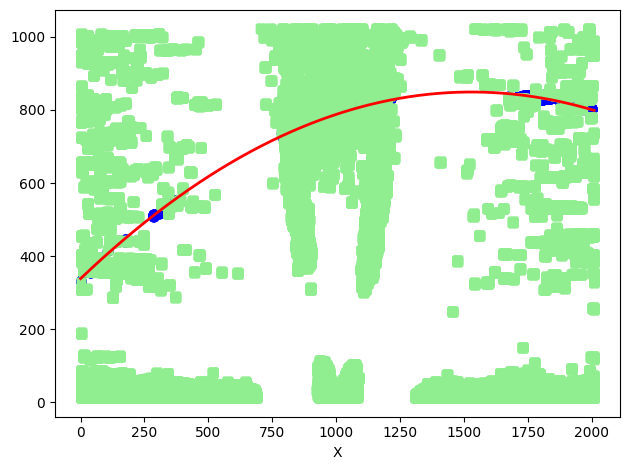

[np.float64(338.28655346207216), np.float64(0.667646351755168), np.float64(-0.00021815108496947566)]


In [ ]:
n = 6
p_data = take_parabola(Data[n]['data'])
size = Data[n]['size']
datalist = np.array([[j, i] for i in range(size[0]) for j in range(size[1]) if p_data[i, j]])
print(p_data)
X = datalist[:, 0]
Y = datalist[:, 1]

X_fit, y_quad_fit, coeff, r2, inlier_mask, outlier_mask = ransac_fit(X, Y)

# inliers
plt.scatter(X[inlier_mask], Y[inlier_mask], c="blue", marker="o", label="Inliers")

# outliers
plt.scatter(
    X[outlier_mask], Y[outlier_mask], c="lightgreen", marker="s", label="Outliers"
)

plt.plot(
    X_fit,
    y_quad_fit,
    label="quadratic (d=2), $R^2=%.2f$" % r2,
    color="red",
    lw=2,
    linestyle="-",
)

plt.xlabel("X")
plt.tight_layout()
plt.show()

print(coeff)

## Делаем маску для вычисления интеграла по дуге

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit  # Ускорение вычислений

@njit
def continuous_stepped_parabola(k, size):
    height, width = size
    step_height = 1
    max_x = min(np.sqrt(height / k), width//2)
    x_range = (-max_x, max_x)

    x = np.linspace(x_range[0], x_range[1], width*2)
    y = k*x**2

    # ступеньки
    y_stepped = np.floor(y / step_height) * step_height

    # обрезаем выходящие за границы по вертикали
    valid_indices = (y_stepped >= 0) & (y_stepped < height)
    x = x[valid_indices]
    y_stepped = y_stepped[valid_indices]

    # скачки
    jumps = np.where(np.diff(y_stepped) != 0)[0] + 1

    # массивы с вертикальными соединениями
    x_extended = []
    y_extended = []

    for i in range(len(x)):
        x_extended.append(x[i])
        y_extended.append(y_stepped[i])

        # вертикальные соединения в местах скачков
        if i in jumps:
            # перед скачком
            x_extended.append(x[i])
            y_extended.append(y_stepped[i-1])

            # после скачка
            x_extended.append(x[i])
            y_extended.append(y_stepped[i])

    # обрезаем выбросы
    points = np.column_stack((np.array(x_extended), np.array(y_extended)))
    points = points[(points[:, 1] >= 0) & (points[:, 1] < height)]
    points = points[(points[:, 0] >= -max_x) & (points[:, 0] < max_x)]

    return points

In [ ]:
@njit
# рисуем линию заданной толщины
def draw_line(mask, x0, y0, x1, y1, thickness):
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)

    if dx > dy:
        steps = dx
    else:
        steps = dy
    if steps == 0:
        return

    x_inc = (x1 - x0)/steps
    y_inc = (y1 - y0)/steps

    for i in range(steps + 1):
        x = int(round(x0 + i*x_inc))
        y = int(round(y0 + i*y_inc))

        # заполняем квадрат
        for dy_t in range(-thickness//2, thickness//2 + 1):
            for dx_t in range(-thickness//2, thickness//2 + 1):
                nx = x + dx_t
                ny = y + dy_t
                if 0 <= nx < mask.shape[1] and 0 <= ny < mask.shape[0]:
                    mask[ny, nx] = 1

In [ ]:
# маска для вычисления интеграла по дуге
@njit
def parabola_to_mask(points, size, thickness=3):
    """
    Создает маску параболы точно заданного размера.

    Параметры:
        points - массив точек параболы в формате (N, 2)
        size - кортеж (height, width) выходной маски
        thickness - толщина линии в пикселях

    Возвращает:
        Бинарную маску заданного размера
    """
    mask = np.zeros(size, dtype=np.uint8)
    height, width = size

    # Масштабируем x к ширине изображения
    x_min, x_max = points[:, 0].min(), points[:, 0].max()
    x_scaled = (points[:, 0] + width//2)

    # y уже в правильном диапазоне (0..height), просто округляем
    y_scaled = np.round(points[:, 1]).astype(np.int32)
    x_scaled = np.round(x_scaled).astype(np.int32)

    # Убедимся, что все точки в пределах изображения
    valid = (x_scaled >= 0) & (x_scaled < width) & (y_scaled >= 0) & (y_scaled < height)
    x_scaled = x_scaled[valid]
    y_scaled = y_scaled[valid]

    # Рисуем все отрезки
    for i in range(len(x_scaled) - 1):
        draw_line(
            mask,
            x_scaled[i], y_scaled[i],
            x_scaled[i+1], y_scaled[i+1],
            thickness
        )

    return mask

## Преобразование Хафа

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.integrate as integrate

@njit
def hough_transform_parabola_kx2(src, k_values, threshold):
    data = src.copy()
    height, width = data.shape

    #аккумулятор
    acc = np.zeros_like(k_values)

    points = np.column_stack(np.where(np.abs(data).astype(np.float32) > np.finfo(np.float32).eps))
    #plt.scatter([p[1] for p in points], [p[0] for p in points])

    for y, x in points:
        rel_x = x-width//2
        for i, k in enumerate(k_values):
            y_pred = k*rel_x**2
            if abs(y_pred - y)/y <= 0.1:  # Проверка попадания в окрестность параболы
                acc[i] += data[y, x]

    detected_ks = [(k_values[i], acc[i]) for i in range(len(k_values)) if acc[i] >= threshold]
    return detected_ks

@njit
def hough_transform_parabola_kx2_enhanced(src, k_values, tolerance=2, threshold=0):
    data = src.copy()
    height, width = data.shape

    #аккумулятор
    acc = np.zeros_like(k_values)

    points = np.column_stack(np.where(np.abs(data).astype(np.float32) > np.finfo(np.float32).eps))
    #plt.scatter([p[1] for p in points], [p[0] for p in points])

    for y, x in points:
        rel_x = x-width//2
        for i, k in enumerate(k_values):
            y_pred = k*rel_x**2
            if abs(y_pred - y)/y <= 0.1:  # Проверка попадания в окрестность параболы
                acc[i] += data[y, x]

    k_bound = 4*height/width**2
    F = lambda k, x: (0.5*x*np.sqrt(1+4*k**2*x**2)+np.arcsinh(2*k*x)/(4*k))
    for i, k in enumerate(k_values):
        xlim = 0
        if k > k_bound:
            xlim = np.sqrt(height/k)
        else:
            xlim = width//2
        integral = F(k, xlim) - F(k, 0)
        acc[i] /= integral

    detected_ks = [(k_values[i], acc[i]) for i in range(len(k_values)) if acc[i] >= threshold]
    return detected_ks

## Вычисление суммы по дуге с заданной кривизной

In [ ]:
@njit
def parabola_integral(data, size, k):
    height, width = data.shape
    k_bound = 4*height/width**2
    F = lambda k, x: (x/2.0*np.sqrt(1+4*k**2*x**2)+np.arcsinh(2*k*x)/(4*k))
    length = 0
    if k > k_bound:
        xlim = np.sqrt(height/k)
        length = F(k, xlim) - F(k, 0)
    else:
        xlim = width//2
        length = F(k, xlim) - F(k, 0)

    points = continuous_stepped_parabola(size=size, k=k)
    mask = parabola_to_mask(points, size=size, thickness=5)
    integral = 0
    for i in range(height):
        for j in range(width):
            integral += mask[i][j]*data[i][j]
    integral /= length
    return integral

In [ ]:
size = (500, 1000)
points = continuous_stepped_parabola(k=0.01, size=size)
mask = parabola_to_mask(points, tuple(size), thickness=5)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(mask, cmap='binary', origin='lower', aspect=0.5)
fig.savefig('mask.png')

#Подытог:
С определением кривизны параболы более-менее разобрались, теперь нужно найти спобоб наиболее быстрого ее определения и найти погрешности ее определения

**Предложения**:
1. Быстро -- сначала логарифмическая шкала, затем ищем в окрестности грубого максимума или два интервала: от 0.01 до 1 с шагом 0.01 и от 1 до 10 с шагом 1
2. Погрешность -- скать полувысоту на полуширине. Высота относительная -- от ближайшего локального минимума

Применим поиск по логарифмической шкале

In [ ]:
@njit
def log_search_k(data, size):
    logkval = np.linspace(-5, 1, 1000)
    kval = np.exp(logkval*np.log(10))
    #small_moving = np.vectorize(lambda k: parabola_integral(data, size, k))(smallk)
    integral_moving = np.zeros_like(kval)
    for i in range(len(kval)):
        integral_moving[i] = parabola_integral(data, size, kval[i])

    kmax = kval[integral_moving.argmax()]
    return integral_moving, kval, logkval, kmax

In [ ]:
LOGC_Data = []
for b in tqdm(B_Data):
    data, size = b.values()
    graph, kval, logkval, k = log_search_k(data, tuple(size))
    detected_ks = np.array(hough_transform_parabola_kx2(data, k_values=kval, threshold=0))
    detected_ks_enhanced = np.array(hough_transform_parabola_kx2_enhanced(data, k_values=kval, threshold=0))
    LOGC_Data.append({'data' : data,
                      'graph_integral': graph/max(graph),
                      'graph_hough': detected_ks[:, 1]/max(detected_ks[:, 1]),
                      'graph_hough_enhanced': detected_ks_enhanced[:, 1]/max(detected_ks_enhanced[:, 1]),
                      'values' : kval,
                      'log_values': logkval,
                      'k' : k,
                      'size': size})

100%|██████████| 20/20 [00:58<00:00,  2.94s/it]


In [ ]:
LOGCRaw_Data = []
for d in tqdm(Cut_Data):
    data, size = d.values()
    graph, kval, logkval, k = log_search_k(data, tuple(size))
    detected_ks = np.array(hough_transform_parabola_kx2(data, k_values=kval, threshold=0))
    detected_ks_enhanced = np.array(hough_transform_parabola_kx2_enhanced(data, k_values=kval, threshold=0))
    LOGCRaw_Data.append({'data' : data,
                      'graph_integral': graph/max(graph),
                      'graph_hough': detected_ks[:, 1]/max(detected_ks[:, 1]),
                      'graph_hough_enhanced': detected_ks_enhanced[:, 1]/max(detected_ks_enhanced[:, 1]),
                      'values' : kval,
                      'log_values': logkval,
                      'k' : k,
                      'size': size})

100%|██████████| 20/20 [03:23<00:00, 10.18s/it]


## Визуализация

In [ ]:
fig, ax = plt.subplots(20, 2, figsize = (20, 200))
for i in tqdm(range(20)):
    data, graph_integral, graph_hough, graph_hough_enhanced, kval, logkval, k, size = LOGC_Data[i].values()
    raw_data = Data[i]['data']
    name = raw_file_data[i][0]
    points = continuous_stepped_parabola(k=k, size=size)
    mask = parabola_to_mask(points, tuple(size), thickness=5)
    masked_array = data & mask

    ax[i][0].imshow(data, cmap='binary', origin='lower', aspect='auto')
    ax[i][0].imshow(masked_array, cmap='binary', origin='lower', aspect='auto', alpha=0.5)
    ax[i][0].set_title(f"file: {name.replace(directory+'/', '')}")
    ax[i][1].plot(logkval, graph_integral, color='red', label='Integral maximization')
    ax[i][1].plot(logkval, graph_hough, color='blue', label='Hough transform')
    ax[i][1].plot(logkval, graph_hough_enhanced, color='green', label='Hough transform enhanced')
    ax[i][1].legend()
fig.savefig('binary_graphs.png', dpi=100)

100%|██████████| 20/20 [00:02<00:00,  7.58it/s]


In [ ]:
fig, ax = plt.subplots(20, 2, figsize = (20, 200))
for i in tqdm(range(20)):
    data, graph_integral, graph_hough, graph_hough_enhanced, kval, logkval, k, size = LOGCRaw_Data[i].values()
    #raw_data = Cut_Data[i]['data']
    name = raw_file_data[i][0]
    points = continuous_stepped_parabola(k=k, size=size)
    mask = parabola_to_mask(points, tuple(size), thickness=5)
    #masked_array = data & mask

    ax[i][0].imshow(data, cmap='binary', origin='lower', aspect='auto')
    ax[i][0].imshow(mask, cmap='binary', origin='lower', aspect='auto', alpha=0.5)
    ax[i][0].set_title(f"file: {name.replace(directory+'/', '')}")
    ax[i][1].plot(logkval, graph_integral, color='red', label='Integral maximization')
    ax[i][1].plot(logkval, graph_hough, color='blue', label='Hough transform')
    ax[i][1].plot(logkval, graph_hough_enhanced, color='green', label='Hough transform enhanced')
    ax[i][1].legend()
fig.savefig('raw_graphs.png', dpi=100)

100%|██████████| 20/20 [00:00<00:00, 57.42it/s]


## Поиск погрешности определенной кривизны

## Для определения погрешности значения кривизны предлагается:
1. Сгладить график характеристики от кривизны
2. Найти полуширину на полувысоте обеих графиков (по методу Хафа и по методу интегрирования вдоль дуги)

Методы сглаживания:
1. Медианное сглаживание в скользящем окне
2. Фильтр Калмана

In [ ]:
def avg_smooth(y, h):
    smoothed = np.zeros_like(y)
    for i in range(len(y)):
        num = len(np.arange(max(i-h, 0), min(i+h, len(y)), 1))
        smoothed[i] = np.sum(y[max(i-h, 0):min(i+h, len(y))])/num
    #smoothed[0] = smoothed[-1] = 0
    return smoothed

## Поиск пиков для бинарного и исходного

In [ ]:
Peak_Data = np.empty_like(Data)
fig, ax = plt.subplots(20, 2, figsize = (20, 200))
for i in tqdm(range(20)):
    _, graph_integral, graph_hough, graph_hough_enhanced, kval, logkval, _, size = LOGC_Data[i].values()
    smooth_hough = avg_smooth(graph_hough_enhanced, 10)
    smooth_integral = avg_smooth(graph_integral, 10)
    peaks1, properties1 = signal.find_peaks(smooth_hough, width = (2), prominence = (0.1, None), rel_height=0.1)
    peaks2, properties2 = signal.find_peaks(smooth_integral, width = (2), prominence = (0.1, None), rel_height=0.1)

    #peaks = peaks2
    #properties = properties2
    ax[i][0].plot(logkval, smooth_hough)
    ax[i][0].plot(logkval, smooth_integral)
    name = raw_file_data[i][0]
    ax[i][0].set_title(f"file: {name.replace(directory+'/', '')}")

    ax[i][1].plot(logkval, smooth_hough, color='red')
    ax[i][1].vlines(logkval[peaks1], 0, max(smooth_hough), linestyle='--')
    ax[i][1].vlines(x=logkval[peaks1], ymin=smooth_hough[peaks1]-properties1["prominences"],
            ymax=smooth_hough[peaks1], color = "C1")
    ax[i][1].hlines(y=properties1["width_heights"],
            xmin=logkval[np.array(properties1["left_ips"], dtype=int)],
            xmax=logkval[np.array(properties1["right_ips"], dtype=int)],
            color = "C1")

    ax[i][1].plot(logkval, smooth_integral, color='red')
    ax[i][1].vlines(logkval[peaks2], 0, max(smooth_integral), linestyle='--')
    ax[i][1].vlines(x=logkval[peaks2], ymin=smooth_integral[peaks2]-properties2["prominences"],
            ymax=smooth_integral[peaks2], color = "C1")
    ax[i][1].hlines(y=properties2["width_heights"],
            xmin=logkval[np.array(properties2["left_ips"], dtype=int)],
            xmax=logkval[np.array(properties2["right_ips"], dtype=int)],
            color = "C2")


    ax[i][1].set_title(f'peaks:{kval[peaks1]}, {kval[peaks2]}')
    Peak_Data[i] = {'filename': name.replace(directory+'/', ''),
                    'graph1': smooth_hough,
                    'peaks1': peaks1,
                    'properties1': properties1,
                    'graph2': smooth_integral,
                    'peaks2': peaks2,
                    'properties2': properties2}
fig.savefig('binary_peaks.png', dpi=100)

100%|██████████| 20/20 [00:00<00:00, 39.53it/s]


In [ ]:
PeakRaw_Data = np.empty_like(Data)
fig, ax = plt.subplots(20, 2, figsize = (20, 200))
for i in tqdm(range(20)):
    _, graph_integral, graph_hough, graph_hough_enhanced, kval, logkval, _, size = LOGCRaw_Data[i].values()
    smooth_hough = avg_smooth(graph_hough_enhanced, 10)
    smooth_integral = avg_smooth(graph_integral, 10)
    peaks1, properties1 = signal.find_peaks(smooth_hough, width = (2), prominence = (0.1, None), rel_height=0.1)
    peaks2, properties2 = signal.find_peaks(smooth_integral, width = (2), prominence = (0.1, None), rel_height=0.1)

    #peaks = peaks2
    #properties = properties2
    ax[i][0].plot(logkval, smooth_hough)
    ax[i][0].plot(logkval, smooth_integral)
    name = raw_file_data[i][0]
    ax[i][0].set_title(f"file: {name.replace(directory+'/', '')}")

    ax[i][1].plot(logkval, smooth_hough, color='red')
    ax[i][1].vlines(logkval[peaks1], 0, max(smooth_hough), linestyle='--')
    ax[i][1].vlines(x=logkval[peaks1], ymin=smooth_hough[peaks1]-properties1["prominences"],
            ymax=smooth_hough[peaks1], color = "C1")
    ax[i][1].hlines(y=properties1["width_heights"],
            xmin=logkval[np.array(properties1["left_ips"], dtype=int)],
            xmax=logkval[np.array(properties1["right_ips"], dtype=int)],
            color = "C1")

    ax[i][1].plot(logkval, smooth_integral, color='red')
    ax[i][1].vlines(logkval[peaks2], 0, max(smooth_integral), linestyle='--')
    ax[i][1].vlines(x=logkval[peaks2], ymin=smooth_integral[peaks2]-properties2["prominences"],
            ymax=smooth_integral[peaks2], color = "C1")
    ax[i][1].hlines(y=properties2["width_heights"],
            xmin=logkval[np.array(properties2["left_ips"], dtype=int)],
            xmax=logkval[np.array(properties2["right_ips"], dtype=int)],
            color = "C2")


    ax[i][1].set_title(f'peaks:{kval[peaks1]}, {kval[peaks2]}')
    PeakRaw_Data[i] = {'filename': name.replace(directory+'/', ''),
                    'graph1': smooth_hough,
                    'peaks1': peaks1,
                    'properties1': properties1,
                    'graph2': smooth_integral,
                    'peaks2': peaks2,
                    'properties2': properties2}
fig.savefig('raw_peaks.png', dpi=100)

100%|██████████| 20/20 [00:00<00:00, 38.63it/s]


##Построение парабол на изображении графиков для бинарного и исходного

In [ ]:
fig, ax = plt.subplots(20, 3, figsize = (30, 200))
for i in tqdm(range(20)):
    data, graph_integral, graph_hough, graph_hough_enhanced, kval, logkval, _, size = LOGC_Data[i].values()
    raw_data = Data[i]['data']

    #mask = parabola_to_mask(points, tuple(size), thickness=0)

    ax[i][0].imshow(raw_data, cmap='binary', origin='lower', aspect='auto')
    ax[i][0].set_xlabel('Безразмерная остаточная частота интерференции', fontsize=12)
    ax[i][0].set_ylabel('Безразмерная задержка', fontsize=12)
    ax[i][1].imshow(data, cmap='binary', origin='lower', aspect='auto')

    filename, graph1, peaks1, properties1, graph2, peaks2, properties2 = Peak_Data[i].values()
    for j in range(len(peaks1)):
        k = kval[peaks1[j]]
        points = continuous_stepped_parabola(k=k, size=size)
        ax[i][1].plot(points[:, 0] + size[1]//2, points[:, 1], color='red')
    ax[i][1].plot([size[1]//2], [0], color='red', label='Hough transform ex')
    for j in range(len(peaks2)):
        k = kval[peaks2[j]]
        points = continuous_stepped_parabola(k=k, size=size)
        ax[i][1].plot(points[:, 0] + size[1]//2, points[:, 1], color='blue')
    ax[i][1].plot([size[1]//2], [0], color='blue', label='Integral maximization')
    ax[i][1].set_title(f"file: {filename}", fontsize=15)
    ax[i][1].set_xlabel('Безразмерная остаточная частота интерференции', fontsize=12)
    ax[i][1].set_ylabel('Безразмерная задержка', fontsize=12)
    ax[i][1].legend()

    ax[i][2].plot(logkval, graph1, color='red', label='Hough trainsform ex')
    ax[i][2].plot(logkval, graph2, color='blue', label='Integral maximization')
    ax[i][2].vlines(logkval[peaks1], 0, max(graph1), linestyle='--')
    ax[i][2].vlines(x=logkval[peaks1], ymin=graph1[peaks1]-properties1["prominences"],
            ymax=graph1[peaks1], color = "C1")
    ax[i][2].hlines(y=properties1["width_heights"],
            xmin=logkval[np.array(properties1["left_ips"], dtype=int)],
            xmax=logkval[np.array(properties1["right_ips"], dtype=int)],
            color = "C1")
    ax[i][2].vlines(logkval[peaks2], 0, max(graph2), linestyle='--')
    ax[i][2].vlines(x=logkval[peaks2], ymin=graph2[peaks2]-properties2["prominences"],
            ymax=graph2[peaks2], color = "C1")
    ax[i][2].hlines(y=properties2["width_heights"],
            xmin=logkval[np.array(properties2["left_ips"], dtype=int)],
            xmax=logkval[np.array(properties2["right_ips"], dtype=int)],
            color = "C1")
    ax[i][2].set_xlabel('Логарифм безразмерной кривизны', fontsize=12)
    ax[i][2].set_ylabel('Нормированная характеристика', fontsize=12)
    #ax[i][2].set_title(f'peaks:{kval[peaks]}')
    ax[i][2].legend()
fig.savefig('binary_graphs_with_peaks.png', dpi=100)

100%|██████████| 20/20 [00:00<00:00, 25.95it/s]


In [ ]:
fig, ax = plt.subplots(20, 3, figsize = (30, 200))
for i in tqdm(range(20)):
    data, graph_integral, graph_hough, graph_hough_enhanced, kval, logkval, _, size = LOGCRaw_Data[i].values()
    raw_data = Data[i]['data']

    ax[i][0].imshow(raw_data, cmap='binary', origin='lower', aspect='auto')
    ax[i][0].set_xlabel('Безразмерная остаточная частота интерференции', fontsize=12)
    ax[i][0].set_ylabel('Безразмерная задержка', fontsize=12)
    ax[i][1].imshow(data, cmap='binary', origin='lower', aspect='auto')

    filename, graph1, peaks1, properties1, graph2, peaks2, properties2 = PeakRaw_Data[i].values()
    for j in range(len(peaks1)):
        k = kval[peaks1[j]]
        points = continuous_stepped_parabola(k=k, size=size)
        ax[i][1].plot(points[:, 0] + size[1]//2, points[:, 1], color='red')
    ax[i][1].plot([size[1]//2], [0], color='red', label='Hough transform ex')
    for j in range(len(peaks2)):
        k = kval[peaks2[j]]
        points = continuous_stepped_parabola(k=k, size=size)
        ax[i][1].plot(points[:, 0] + size[1]//2, points[:, 1], color='blue')
    ax[i][1].plot([size[1]//2], [0], color='blue', label='Integral maximization')
    ax[i][1].set_xlabel('Безразмерная остаточная частота интерференции', fontsize=12)
    ax[i][1].set_ylabel('Безразмерная задержка', fontsize=12)
    ax[i][1].set_title(f"file: {filename}", fontsize=15)
    ax[i][1].legend()

    ax[i][2].plot(logkval, graph1, color='red', label='Hough trainsform ex')
    ax[i][2].plot(logkval, graph2, color='blue', label='Integral maximization')

    ax[i][2].vlines(logkval[peaks1], 0, max(graph1), linestyle='--')
    ax[i][2].vlines(x=logkval[peaks1], ymin=graph1[peaks1]-properties1["prominences"],
            ymax=graph1[peaks1], color = "C1")
    ax[i][2].hlines(y=properties1["width_heights"],
            xmin=logkval[np.array(properties1["left_ips"], dtype=int)],
            xmax=logkval[np.array(properties1["right_ips"], dtype=int)],
            color = "C1")

    ax[i][2].vlines(logkval[peaks2], 0, max(graph2), linestyle='--')
    ax[i][2].vlines(x=logkval[peaks2], ymin=graph2[peaks2]-properties2["prominences"],
            ymax=graph2[peaks2], color = "C1")
    ax[i][2].hlines(y=properties2["width_heights"],
            xmin=logkval[np.array(properties2["left_ips"], dtype=int)],
            xmax=logkval[np.array(properties2["right_ips"], dtype=int)],
            color = "C1")
    ax[i][2].set_xlabel('Логарифм безразмерной кривизны', fontsize=12)
    ax[i][2].set_ylabel('Нормированная характеристика', fontsize=12)
    #ax[i][2].set_title(f'peaks:{kval[peaks]}')
    ax[i][2].legend()
fig.savefig('raw_graphs_with_peaks.png', dpi=100)

100%|██████████| 20/20 [00:01<00:00, 15.33it/s]


## Расчет погрешности, занесение в таблицу

In [ ]:
full_spectra_info = copy.deepcopy(spectra_info)
full_spectra_info['hough'] = ''
full_spectra_info['integral'] = ''
full_spectra_info['raw_hough'] = ''
full_spectra_info['raw_integral'] = ''

for i in tqdm(range(20)):
    filename, _, peaks1, properties1, _, peaks2, properties2 = Peak_Data[i].values()
    filename, _, raw_peaks1, raw_properties1, _, raw_peaks2, raw_properties2 = PeakRaw_Data[i].values()
    #print(filename)
    wide, obs_time = full_spectra_info.loc[full_spectra_info['file'] == filename][['wide', 'obs_time']].values[0]
    dt, df = 1.0/wide, 1.0/float(obs_time)*100/6
    coeff = dt/df**2

    k1 = []
    for i in range(len(peaks1)):
        k = coeff*kval[peaks1[i]]
        left = coeff*kval[np.array(properties1["left_ips"], dtype=int)[i]]
        right = coeff*kval[np.array(properties1["right_ips"], dtype=int)[i]]
        k1.append(str(fr"\num{{{k:.5f}({k-left:.5f}:{right-k:.5f})}}"))
    k1 = np.array(k1, dtype=str)

    k2 = []
    for i in range(len(peaks2)):
        k = coeff*kval[peaks2[i]]
        left = coeff*kval[np.array(properties2["left_ips"], dtype=int)[i]]
        right = coeff*kval[np.array(properties2["right_ips"], dtype=int)[i]]
        k2.append(str(fr"\num{{{k:.5f}({k-left:.5f}:{right-k:.5f})}}"))
    k2 = np.array(k2, dtype=str)

    raw_k1 = []
    for i in range(len(raw_peaks1)):
        k = coeff*kval[raw_peaks1[i]]
        left = coeff*kval[np.array(raw_properties1["left_ips"], dtype=int)[i]]
        right = coeff*kval[np.array(raw_properties1["right_ips"], dtype=int)[i]]
        raw_k1.append(str(fr"\num{{{k:.5f}({k-left:.5f}:{right-k:.5f})}}"))
    raw_k1 = np.array(raw_k1, dtype=str)

    raw_k2 = []
    for i in range(len(raw_peaks2)):
        k = coeff*kval[raw_peaks2[i]]
        left = coeff*kval[np.array(raw_properties2["left_ips"], dtype=int)[i]]
        right = coeff*kval[np.array(raw_properties2["right_ips"], dtype=int)[i]]
        raw_k2.append(str(fr"\num{{{k:.5f}({k-left:.5f}:{right-k:.5f})}}"))
    raw_k2 = np.array(raw_k2, dtype=str)

    idx = full_spectra_info.index[full_spectra_info['file'] == filename].tolist()[0]
    full_spectra_info.at[idx, 'hough'] = k1
    full_spectra_info.at[idx, 'raw_hough'] = raw_k1
    full_spectra_info.at[idx, 'integral'] = k2
    full_spectra_info.at[idx, 'raw_integral'] = raw_k2


100%|██████████| 20/20 [00:00<00:00, 561.71it/s]


In [ ]:
pd.set_option('display.max_colwidth', None)

full_spectra_info.sort_values(by='pulsar', ascending=False)[['file', 'pulsar', 'hough', 'integral', 'raw_hough', 'raw_integral']]

,file,pulsar,hough,integral,raw_hough,raw_integral
15,raks02aa.514.lcp-rcp.averaged.secspec.4096x636.bin,B1933+16,"[\num{0.01936(0.00273:0.00318)}, \num{0.15201(0.04880:0.05692)}]",\num{0.18448(0.05392:0.11485)},\num{0.01574(0.00817:0.00842)},\num{0.16746(0.14964:0.21648)}
14,raks02aa.514.lcp-rcp.averaged.secspec.1133x395.bin,B1933+16,"[\num{0.00677(0.00119:0.00111)}, \num{0.05463(0.01204:0.01353)}]","[\num{0.00686(0.00113:0.00113)}, \num{0.06102(0.01345:0.02640)}]",\num{0.00845(0.00294:0.00796)},"[\num{0.00715(0.00084:0.00095)}, \num{0.06187(0.03131:0.09658)}]"
5,rags04ao..LCP-771-USB.arc.512x144.bin,B1929+10,\num{0.34544(0.06471:0.07963)},\num{0.39122(0.09040:0.11757)},\num{0.09813(0.04247:0.04842)},\num{0.35512(0.23603:0.59287)}
6,secspec_slice_512x201.bin,B1929+10,"[\num{0.00948(0.00178:0.00141)}, \num{0.42507(0.12006:0.06304)}]","[\num{0.00935(0.00154:0.00200)}, \num{0.40219(0.07079:0.10659)}]","[\num{0.01648(0.00233:0.00918)}, \num{0.34544(0.06857:0.15636)}]","[\num{0.01946(0.00365:0.00585)}, \num{0.41347(0.11265:0.16275)}]"
7,rags04ap_gb_ll_scnd.modified.512x3380.bin,B1237+25,"[\num{0.02341(0.00126:0.00133)}, \num{0.58717(0.10335:0.11565)}]",\num{0.78503(0.17299:0.32424)},\num{0.61204(0.21339:0.12054)},\num{0.74279(0.20237:0.36649)}
8,rags04ar_ar_rr_scnd.modified.512x3770.bin,B1237+25,"[\num{0.00684(0.00037:0.00049)}, \num{0.38778(0.04538:0.07637)}]","[\num{0.00674(0.00071:0.00100)}, \num{0.42132(0.08827:0.14198)}]","[\num{0.00703(0.00047:0.00040)}, \num{0.37720(0.07066:0.09342)}]",\num{0.40420(0.10603:0.15910)}
11,rags29j.771-USB.combined.512x516.1of1.frdelay.ifft.tr.fft.tr_amp.dat,B1237+25,"[\num{0.01137(0.00474:0.00224)}, \num{0.52419(0.08625:0.09463)}]","[\num{0.00691(0.00089:0.00092)}, \num{0.56172(0.11150:0.12000)}]",\num{0.01253(0.00329:0.00808)},\num{0.02756(0.02015:0.41038)}
10,rags29g.514-USB-4096x2019.combined.linear.1of1.frdelay.ifft.tr.fft.tr_amp.dat,B1133+16,"[\num{0.00056(0.00009:0.00018)}, \num{0.07068(0.01481:0.01873)}]","[\num{0.00059(0.00012:0.00023)}, \num{0.07368(0.01544:0.02214)}]",\num{0.00628(0.00219:0.00297)},\num{0.06071(0.03667:0.05085)}
17,raks24e.LCP-514-USB-2048x1986.combined.smooth.1of1.frdelay.ifft.tr.fft.tr_amp.dat,B1133+16,\num{0.08778(0.02028:0.02797)},\num{0.21567(0.13923:0.06481)},\num{0.06844(0.03320:0.03519)},\num{0.09024(0.06200:0.62806)}
12,rags29l.LCP-514-USB-2048x2012.combined.smooth.1of1.frdelay.ifft.tr.fft.tr_amp.dat,B1133+16,"[\num{0.00317(0.00056:0.00047)}, \num{0.07019(0.01912:0.01738)}]",\num{0.07521(0.01896:0.01734)},\num{0.00340(0.00089:0.00219)},\num{0.03280(0.02593:0.05599)}


In [ ]:
full_spectra_info.to_excel('full_spectra_info.xlsx', index=False)